### Import the necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# 1st Part - Pretreatment 

In [5]:
# Read the log file into a DataFrame
df = pd.read_csv('data/smart_oxygen_concentrator_activities.txt',
                 sep='--',
                 names=['timestamp', 'device_id', 'x_position', 'y_position', 'oxygen_concentration', 'use_duration_in_min', 'level', 'temperature', 'patient_oxygen_saturation'],
                 engine='python')

# Select only the columns that we want to keep
df = df[['device_id', 'x_position', 'y_position', 'oxygen_concentration', 'use_duration_in_min', 'level', 'temperature', 'patient_oxygen_saturation']]

# Count the number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Found {num_duplicates} duplicate rows.")

# Write the data to a CSV file
df.to_csv('data/smart_oxygen_concentrator_data.csv', index=False)

# Check if head of the data frame
df.head()


Found 5 duplicate rows.


,device_id,x_position,y_position,oxygen_concentration,use_duration_in_min,level,temperature,patient_oxygen_saturation
0,2018,131,80,93,160,1,37.0,90.0
1,2019,60,389,93,160,1,38.0,89.0
2,2020,600,211,95,160,2,38.0,90.0
3,2018,131,80,93,220,1,40.0,90.0
4,2019,60,389,93,220,1,39.0,89.0


# Part 2 - Prediction 
## Building and training a Basian Regression model
For starters, let's take build a basian regression model and have a look at it's performance

Mean squared error: 2.28
R-squared score: 0.81


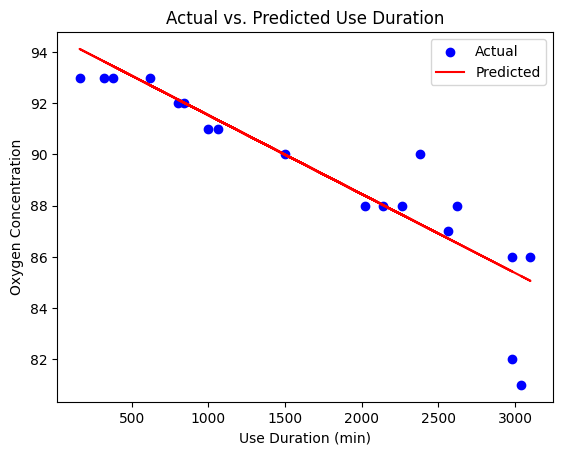

In [6]:
DEVICE_ID = 2018
OXYGEN_CONCENTRATOR_LOG = 'data/smart_oxygen_concentrator_data.csv'
THRESHOLD = 80

df = pd.read_csv(OXYGEN_CONCENTRATOR_LOG)

# Select only the data for device with ID 2018
df = df[df['device_id'] == DEVICE_ID]

# Define the input and output variables
X = df[['level', 'use_duration_in_min']]
y = df['oxygen_concentration']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Creating and training model
model = BayesianRidge()
model.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = model.predict(X_test)

# Print the mean squared error and R-squared score
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('R-squared score: %.2f' % r2_score(y_test, y_pred))

# Plot the predicted versus actual values
plt.scatter(X_test['use_duration_in_min'], y_test, color='blue', label='Actual')
plt.plot(X_test['use_duration_in_min'], y_pred, color='red', label='Predicted')
plt.xlabel('Use Duration (min)')
plt.ylabel('Oxygen Concentration')
plt.title('Actual vs. Predicted Use Duration')
plt.legend()
plt.show()

The Bayesian regression model has a mean squared error (MSE) of 2.28 and an R-squared score of 0.81. The MSE represents the average squared difference between the actual and predicted values of the target variable, where a lower value indicates a better fit. The R-squared score represents the proportion of the variance in the target variable that is explained by the model, where a higher value indicates a better fit.

In this case, the MSE of 2.28 indicates that the model has a relatively low average squared difference between the actual and predicted values, which suggests that the model is fitting the data reasonably well. The R-squared score of 0.81 indicates that the model is able to explain a relatively large proportion of the variance in the target variable, which suggests that the model is a good fit for the data.

We can see that as the use duration increases, the predicted oxygen concentration decreases. This suggests that there is a negative relationship between use duration and oxygen concentration, which is consistent with our understanding of the operating principle of an oxygen concentrator. The fact that the model has a relatively low MSE and a relatively high R-squared score suggests that the model is able to capture this relationship reasonably well, and can be used to make predictions of the oxygen concentration for a given device, based on its use duration and level.

## Predicting when a filter change is needed

### using use_duration_min as output variable
A better approach would be to use use_duration_min as an output variable and predict when the oxygen concentration will reach 80. This approach would allow us to estimate how long the device needs to be used to reach a certain oxygen concentration level and could be useful for determining the optimal duration of device use in a given scenario. By going this way, we significantly decrease the complexity of our code and the final prediction should be different since we changed the configuration of the model.



In [7]:
DEVICE_ID = 2018
OXYGEN_CONCENTRATOR_LOG = 'data/smart_oxygen_concentrator_data.csv'
THRESHOLD = 80

def train_model(device_id, data_set_path = OXYGEN_CONCENTRATOR_LOG):
    # Check if data_set_path is not None
    if data_set_path is None:
        raise ValueError("data_set_path must not be None")

    # Load the data from the CSV file
    df = pd.read_csv(data_set_path)
    
    # Select only the data for device with ID 2018
    df = df[df['device_id'] == device_id]

    # Check if the filtered data frame is not empty
    if df.empty:
        raise ValueError("No data found for device ID {device_id}")

    # Define the input and output variables
    X = df[['level', 'oxygen_concentration']]
    y = df['use_duration_in_min']

    # Splitting dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    # Creating and training model
    model = BayesianRidge()
    model.fit(X_train, y_train)

    return model


basian_regression_model = train_model(device_id = DEVICE_ID)

In [8]:
def predict(device_id, model, level=1, oxygen_concentration_threshold = 80, data_set_path = OXYGEN_CONCENTRATOR_LOG):
    # Check if data_set_path is not None
    if data_set_path is None:
        raise ValueError("data_set_path must not be None")

    # Check if device_id is an integer
    if not isinstance(device_id, int):
        raise ValueError("device_id must be an integer")
    
    # Load the data from the CSV file
    df = pd.read_csv(data_set_path)

    # Select only the data for the given device ID
    df = df[df['device_id'] == device_id]
    # Check if the filtered data frame is not empty
    if df.empty:
        raise ValueError("No data found for device ID {device_id}")
    # Validate the input arguments
    if level not in [1, 2]:
        raise ValueError("Invalid level: must be either 1 or 2")
    if oxygen_concentration_threshold <= 0:
        raise ValueError("Invalid threshold: must be a positive number")

   # Define the input variables
    X =  pd.DataFrame(np.array([[level, oxygen_concentration_threshold]]), columns=['level', 'oxygen_concentration'])
    y_pred = model.predict(X)

    return y_pred[0]
predicted_time_in_minutes = predict(device_id=DEVICE_ID, model=basian_regression_model, oxygen_concentration_threshold = THRESHOLD)

# Convert the duration to days, hours, and minutes
days = predicted_time_in_minutes // (24 * 60)
hours = (predicted_time_in_minutes // 60) % 24
minutes = predicted_time_in_minutes % 60
print(f"The predicted time where the filter(s) needs change in device #{DEVICE_ID} is: {days:.0f} days, {hours:.0f} hours, and {minutes:.0f} minutes from installation")

The predicted time where the filter in device #2018 is: 2 days, 21 hours, and 28 minutes from installation


### Using oxygen_concentration as output variable
This answer is based on the initial prompt. You will notice that the final result is different compared to the first approach where we reversed oxygen_concentration and use_duration_in_min

In [9]:
DEVICE_ID = 2018
OXYGEN_CONCENTRATOR_LOG = 'data/smart_oxygen_concentrator_data.csv'
THRESHOLD = 80

def train_model(device_id, data_set_path = OXYGEN_CONCENTRATOR_LOG):
    # Check if data_set_path is not None
    if data_set_path is None:
        raise ValueError("data_set_path must not be None")
    
    # Load the data from the CSV file
    df = pd.read_csv(data_set_path)
    
    # Select only the data for device with ID 2018
    df = df[df['device_id'] == device_id]

    # Check if the filtered data frame is not empty
    if df.empty:
        raise ValueError("No data found for device ID {device_id}")

    # Define the input and output variables
    X = df[['level', 'use_duration_in_min']]
    y = df['oxygen_concentration']

    # Splitting dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    # Creating and training model
    model = BayesianRidge()
    model.fit(X_train, y_train)

    return model


basian_regression_model = train_model(device_id = DEVICE_ID)

In [10]:
def predict(device_id, model, level=1, threshold = 80, data_set_path = OXYGEN_CONCENTRATOR_LOG):
    # Check if data_set_path is not None
    if data_set_path is None:
        raise ValueError("data_set_path must not be None")

    # Check if device_id is an integer
    if not isinstance(device_id, int):
        raise ValueError("device_id must be an integer")
    
    # Load the data from the CSV file
    df = pd.read_csv(data_set_path)

    # Select only the data for the given device ID
    df = df[df['device_id'] == device_id]
    # Check if the filtered data frame is not empty
    if df.empty:
        raise ValueError("No data found for device ID {device_id}")
    # Validate the input arguments
    if level not in [1, 2]:
        raise ValueError("Invalid level: must be either 1 or 2")
    if threshold <= 0:
        raise ValueError("Invalid threshold: must be a positive number")

    # Define the input variables
    # Use the trained BayesianRidge model to predict oxygen concentration at a series of time points
    t = np.arange(df['use_duration_in_min'].min(), df['use_duration_in_min'].max() + 4000)
    X =  pd.DataFrame(np.column_stack((np.ones_like(t), t)), columns=['level', 'use_duration_in_min'])
    y_pred = model.predict(X)

    # Find the first time point where the predicted oxygen concentration is less than 80
    idx = np.where(y_pred < 80)[0]
    if len(idx) == 0:
        # No time points were found where the predicted concentration is less than 80
        return None
    else:
        # Return the first time point where the predicted concentration is less than 80
        return t[idx[0]]

predicted_time_in_minutes = predict(device_id=DEVICE_ID, model=basian_regression_model)

# Format output
if predicted_time_in_minutes is None:
    print("No time points were found where the predicted concentration is less than 80")
else:
    # Convert the duration to days, hours, and minutes
    days = predicted_time_in_minutes // (24 * 60)
    hours = (predicted_time_in_minutes // 60) % 24
    minutes = predicted_time_in_minutes % 60
    print(f"The predicted time where the filter(s) needs change in device {DEVICE_ID} is: {days} days, {hours} hours, and {minutes} minutes from installation")

The predicted time where the filter in device #2018 is: 3 days, 7 hours, and 4 minutes from installation
